In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50
# importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.regularizers import l2, l1
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, save_img
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve


plt.style.use('fivethirtyeight')

In [2]:
train_data_path = '../data/aug_red_eye/training_aug/train'
val_data_path = '../data/aug_red_eye/training_aug/val'
test_data_path = '../data/aug_red_eye/training_aug/test'

In [3]:
# image parameters:

WIDTH = 128
HEIGHT = 128
CHANNELS = 3
CLASSES = 2

In [4]:
batchsize = 4
train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1./255,
        fill_mode="nearest")
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_data_path,
        color_mode="rgb",
        target_size=(WIDTH, HEIGHT),
        batch_size=batchsize,
        class_mode="categorical",
        subset='training',
        shuffle=True,
        seed=42
        )
validation_generator = val_datagen.flow_from_directory(
        val_data_path,
        color_mode="rgb",
        target_size=(WIDTH, HEIGHT),
        batch_size=batchsize,
        class_mode="categorical",
        subset='training',
        shuffle=True,
        seed=42
        )

test_generator = test_datagen.flow_from_directory(
        test_data_path,
        color_mode="rgb",
        target_size=(WIDTH, HEIGHT),
        batch_size=11,
        shuffle = False,
        class_mode='categorical',
        seed = 42)

Found 949 images belonging to 2 classes.
Found 169 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


In [6]:
resnet50_model = Sequential()

pretrain_model_resnet50 = tf.keras.applications.ResNet50(include_top=False,
                                                        input_shape = (WIDTH,HEIGHT,CHANNELS),
                                                        pooling = 'max',
                                                        classes = 2,
                                                        weights = 'imagenet')

for layer in pretrain_model_resnet50.layers:
    layer.trainable = False

resnet50_model.add(pretrain_model_resnet50)
resnet50_model.add(Flatten())
resnet50_model.add(Dense(512, activation = 'relu'))
resnet50_model.add(Dense(CLASSES, activation='sigmoid'))



In [7]:
resnet50_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
# compling the model
resnet50_model.compile(optimizer=keras.optimizers.Adam(0.5e-4), 
                loss=keras.losses.binary_crossentropy, metrics=['accuracy','Recall','Precision'])

cb = keras.callbacks.EarlyStopping(monitor="accuracy",
                                    min_delta=0.005,
                                    patience=30,
                                    verbose=1,
                                    mode="min",
                                    baseline=None,
                                    restore_best_weights=False)

In [9]:
history = resnet50_model.fit(train_generator,
        batch_size = batchsize, 
        epochs = 100,
        verbose = 1, 
        validation_data = validation_generator)

Epoch 1/50
238/238 [==============================] - 16s 23ms/step - loss: 0.6806 - accuracy: 0.5606 - recall: 0.5659 - precision: 0.5611 - val_loss: 0.6816 - val_accuracy: 0.5621 - val_recall: 0.5621 - val_precision: 0.5460
Epoch 2/50
238/238 [==============================] - 4s 17ms/step - loss: 0.6533 - accuracy: 0.6238 - recall: 0.6322 - precision: 0.6237 - val_loss: 0.6669 - val_accuracy: 0.6036 - val_recall: 0.5976 - val_precision: 0.5906
Epoch 3/50
238/238 [==============================] - 4s 17ms/step - loss: 0.6333 - accuracy: 0.6301 - recall: 0.6259 - precision: 0.6286 - val_loss: 0.6691 - val_accuracy: 0.5917 - val_recall: 0.6095 - val_precision: 0.5852
Epoch 4/50
238/238 [==============================] - 4s 17ms/step - loss: 0.6174 - accuracy: 0.6639 - recall: 0.6586 - precision: 0.6607 - val_loss: 0.6556 - val_accuracy: 0.6213 - val_recall: 0.6154 - val_precision: 0.6118
Epoch 5/50
238/238 [==============================] - 4s 17ms/step - loss: 0.6104 - accuracy: 0.680

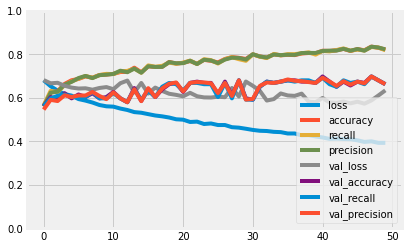

In [11]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1) # set the y range to [0,1]
plt.show()


In [13]:
print('Model Evalution Score on Validation set')
print(resnet50_model.evaluate(validation_generator))

Model Evalution Score on Validation set
43/43 [==============================] - 1s 18ms/step - loss: 0.6344 - accuracy: 0.6627 - recall: 0.6627 - precision: 0.6627
[0.634433388710022, 0.6627218723297119, 0.6627218723297119, 0.6627218723297119]


In [14]:
print('Model Evalution Score')
print(resnet50_model.evaluate(test_generator))

Model Evalution Score
1/1 [==============================] - 1s 596ms/step - loss: 0.3116 - accuracy: 0.8182 - recall: 0.8182 - precision: 0.8182
[0.31159064173698425, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141]


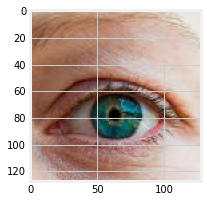

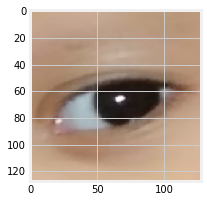

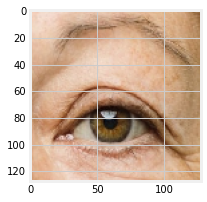

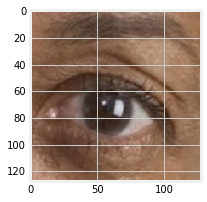

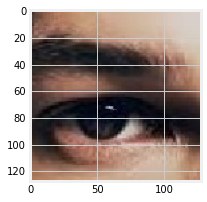

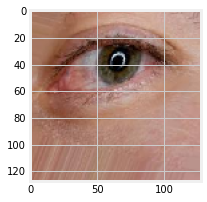

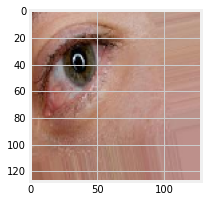

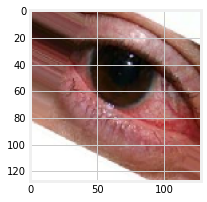

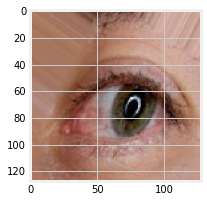

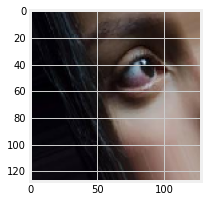

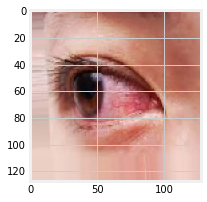

In [15]:
x_test, y_test = test_generator.__next__()

#print(y_test)
y_series_test = []
# checking/ verifying if the image and masks are coorelated
for i in range(0,11):
    image = x_test[i]
    plt.subplot(1,2,1)
    plt.imshow(image)
    y_series_test.append(int(y_test[i][1]))
    plt.show()

In [16]:
y_pred_test = resnet50_model.predict(test_generator)
y_pred_test = y_pred_test.argmax(axis=-1)
cf_matrix = confusion_matrix(y_series_test, y_pred_test)
print(cf_matrix)

1/1 [==============================] - 1s 815ms/step
[[3 2]
 [0 6]]


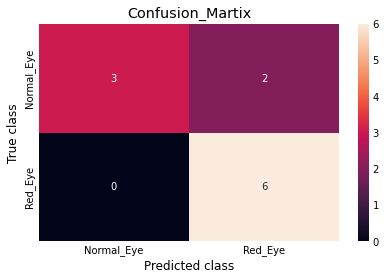

In [17]:
LABELS = ["Normal_Eye","Red_Eye"]
sns.heatmap(cf_matrix, annot=True, xticklabels=LABELS, yticklabels=LABELS,fmt = 'd')
plt.title("Confusion_Martix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

In [18]:
pred_path = '../data/aug_red_eye/prediction_images'
number_of_images = '../data/aug_red_eye/prediction_images/prediction'
img_list_len = len(os.listdir(number_of_images))
batch_size = int(img_list_len)
pred_datagen = ImageDataGenerator(rescale=1./255)
pred_generator = pred_datagen.flow_from_directory(
    directory= pred_path,
    target_size=(WIDTH, HEIGHT),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 9 images belonging to 1 classes.


1/1 [==============================] - 1s 1s/step
Red_Eye


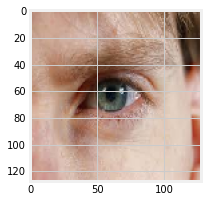

1/1 [==============================] - 0s 48ms/step
Normal_Eye


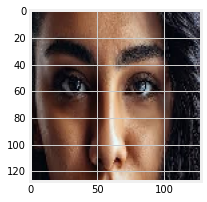

1/1 [==============================] - 0s 49ms/step
Red_Eye


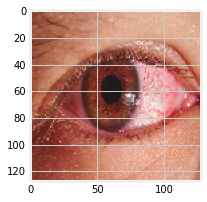

1/1 [==============================] - 0s 50ms/step
Red_Eye


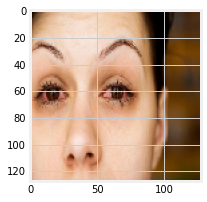

1/1 [==============================] - 0s 59ms/step
Red_Eye


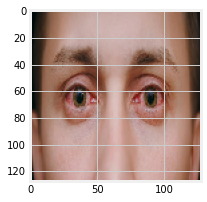

1/1 [==============================] - 0s 53ms/step
Normal_Eye


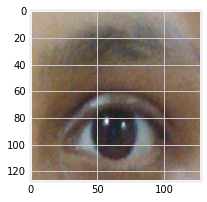

1/1 [==============================] - 0s 49ms/step
Normal_Eye


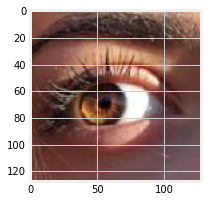

1/1 [==============================] - 0s 56ms/step
Normal_Eye


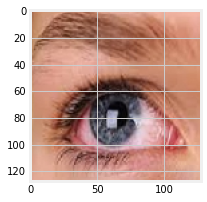

In [19]:
x_pred = pred_generator.__next__()


# checking/ verifying if the image and masks are coorelated
for i in range(0,batch_size-1):
    image = x_pred[i]
    plt.subplot(1,2,1)
    predict=resnet50_model.predict(pred_generator)
    y_classes = predict.argmax(axis=-1)
    if y_classes[i] == 0:
        print('Normal_Eye')
    else:
        print('Red_Eye')
    #print(y_classes[i])
    plt.imshow(image)
    plt.show()
